In [1]:
%matplotlib inline
import numpy as np
from rnn.arch import RNN
from vae.arch import VAE
import matplotlib.pyplot as plt
from gym.utils import seeding
from IPython import display
import time
from tensorflow.keras.utils import plot_model

np.set_printoptions(precision=4, suppress = True)

In [2]:
rnn = RNN()
rnn.set_weights('./rnn/weights.h5')

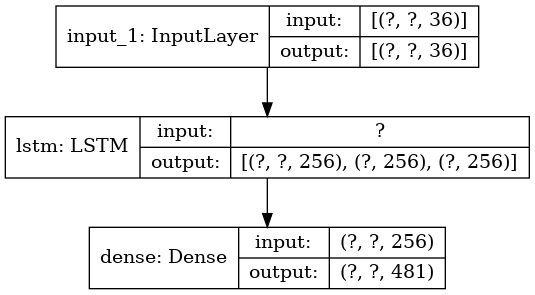

In [3]:
plot_model(rnn.model, to_file='./rnn/model.png', show_shapes=True)

In [4]:
vae = VAE()
vae.set_weights('./vae/weights.h5')

In [5]:
# obs_data = np.load('./data/obs_data_car_racing_' + str(batch_num) + '.npy') 
# action_data = np.load('./data/action_data_car_racing_' + str(batch_num) + '.npy')
# reward_data = np.load('./data/reward_data_car_racing_' + str(batch_num) + '.npy') 
# done_data = np.load('./data/done_data_car_racing_' + str(batch_num) + '.npy')
rnn_files = np.load('./data/rnn_files.npz') 
rnn_input = rnn_files['rnn_input']
rnn_output = rnn_files['rnn_output']

initial_mu = np.load('./data/initial_z.npz')['initial_mu']
initial_log_var = np.load('./data/initial_z.npz')['initial_log_var']

In [7]:
rollout_files = np.load('./data/rollout/3253726.npz') 
obs_file = rollout_files['obs']
action_file = rollout_files['action']
reward_file = rollout_files['reward']
done_file = rollout_files['done']

series_files = np.load('./data/series/3253726.npz') 
mu_file = series_files['mu']
log_var_file = series_files['log_var']
action_2_file = series_files['action']
reward_2_file = series_files['reward']
done_2_file = series_files['done']



In [8]:

hot_zs = np.where(np.exp(initial_log_var[0]/2) < 0.5)[0]
hot_zs

array([ 4,  7, 22])

In [9]:
GAUSSIAN_MIXTURES = 5
Z_DIM = 32
z_dim = 32

def get_mixture_coef(z_pred):

    log_pi, mu, log_sigma = np.split(z_pred, 3, 1)
    log_pi = log_pi - np.log(np.sum(np.exp(log_pi), axis = 1, keepdims = True))

    return log_pi, mu, log_sigma


In [10]:
def get_pi_idx(x, pdf):
  # samples from a categorial distribution
    N = pdf.size
    accumulate = 0
    for i in range(0, N):
        accumulate += pdf[i]
        if (accumulate >= x):
            return i
    random_value = np.random.randint(N)
    #print('error with sampling ensemble, returning random', random_value)
    return random_value

In [11]:
def sample_z(mu, log_sigma):
    z =  mu + (np.exp(log_sigma)) * np_random.randn(*log_sigma.shape) * 0.5
    return z

In [12]:
np_random, seed = seeding.np_random()

In [13]:
def sample_next_mdn_output(obs, h, c):
    
    d = GAUSSIAN_MIXTURES * Z_DIM
#     print(np.array([[obs]]))
#     print(np.array([h]))
#     print(np.array([c]))
    
#     print('------')
#     print(np.array([[obs]]).shape)
#     print(np.array([h]).shape)
#     print(np.array([c]).shape)
#     print('------')
    
    out = rnn.forward.predict([np.array([[obs]]),np.array([h]),np.array([c])])
    
    y_pred = out[0][0][0]
    new_h = out[1][0]
    new_c = out[2][0]
    
    z_pred = y_pred[:3*d]
    rew_pred = y_pred[-1]

    z_pred = np.reshape(z_pred, [-1, GAUSSIAN_MIXTURES * 3])

    log_pi, mu, log_sigma = get_mixture_coef(z_pred)
    
    chosen_log_pi = np.zeros(z_dim)
    chosen_mu = np.zeros(z_dim)
    chosen_log_sigma = np.zeros(z_dim)
    
    # adjust temperatures
    pi = np.copy(log_pi)
#     pi -= pi.max()
    pi = np.exp(pi)
    pi /= pi.sum(axis=1).reshape(z_dim, 1)
    
#     print(pi)

    for j in range(z_dim):
        
        idx = get_pi_idx(np_random.rand(), pi[j])
#         print(idx)
        chosen_log_pi[j] = idx
        chosen_mu[j] = mu[j,idx]
        chosen_log_sigma[j] = log_sigma[j,idx]
        
    next_z = sample_z(chosen_mu, chosen_log_sigma)

    if rew_pred > 0:
        next_reward = 1
    else:
        next_reward = 0

    return next_z, chosen_mu, chosen_log_sigma, chosen_log_pi, rew_pred, next_reward, new_h, new_c

In [14]:
run_idx = 10

idx = 0

# real = obs_data[run_idx]
obs = rnn_input[run_idx]
actual = rnn_output[run_idx] 

print(obs.shape)
print(actual.shape)


(299, 36)
(299, 33)


3.2491191925552445
[[-0.0147]]
[8.0954 8.1202 8.1365 7.7185 7.8373]


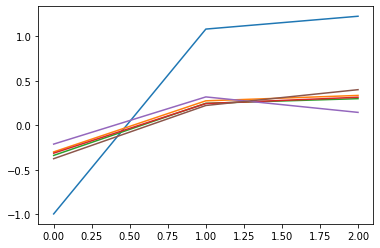

In [15]:
d = GAUSSIAN_MIXTURES * Z_DIM

print(sum(np.abs(obs[idx,hot_zs])))

plt.plot(actual[idx,hot_zs])


y_pred = rnn.model.predict(np.array([[obs[idx,:]]]))

# print(y_pred)

z_pred = y_pred[:,:,:(3*d)]
rew_pred = y_pred[:,:,-1]



print(rew_pred)

z_pred = np.reshape(z_pred, [-1, GAUSSIAN_MIXTURES * 3])

log_pi, mu, log_sigma = np.split(z_pred, 3, 1)


plt.plot(mu[hot_zs])

log_pi = log_pi - np.log(np.sum(np.exp(log_pi), axis = 1, keepdims = True))

print(sum(np.abs(mu)))


In [16]:
current_z = obs[idx]
i = idx
current_h = np.zeros(256)
current_c = np.zeros(256)

In [17]:
next_z = obs[idx,:]
next_h = np.zeros(256)
next_c = np.zeros(256)
# next_z_decoded = vae.decoder.predict(np.array([next_z]))[0]
# plt.imshow( next_z_decoded)
# plt.show()

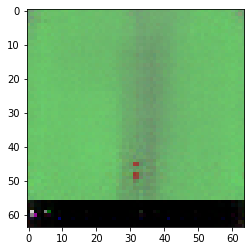

299


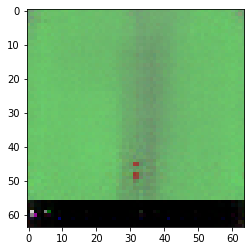

In [18]:
#SIMULATE TURNING IN THE DREAM
for i in range(300):
    next_z, chosen_mu, chosen_log_sigma, chosen_pi, rew_pred, next_reward, next_h, next_c \
    = sample_next_mdn_output(next_z, next_h, next_c)
        
    next_z_decoded = vae.decoder.predict(np.array([next_z]))[0]
    next_z = np.concatenate([next_z, [1,1,0], [next_reward]])
    
    plt.gca().cla() 
    plt.imshow(next_z_decoded)
    
    print(next_reward)
    
    display.clear_output(wait=True)
    display.display(plt.gcf()) 
    
    print(i)


(33, 299)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

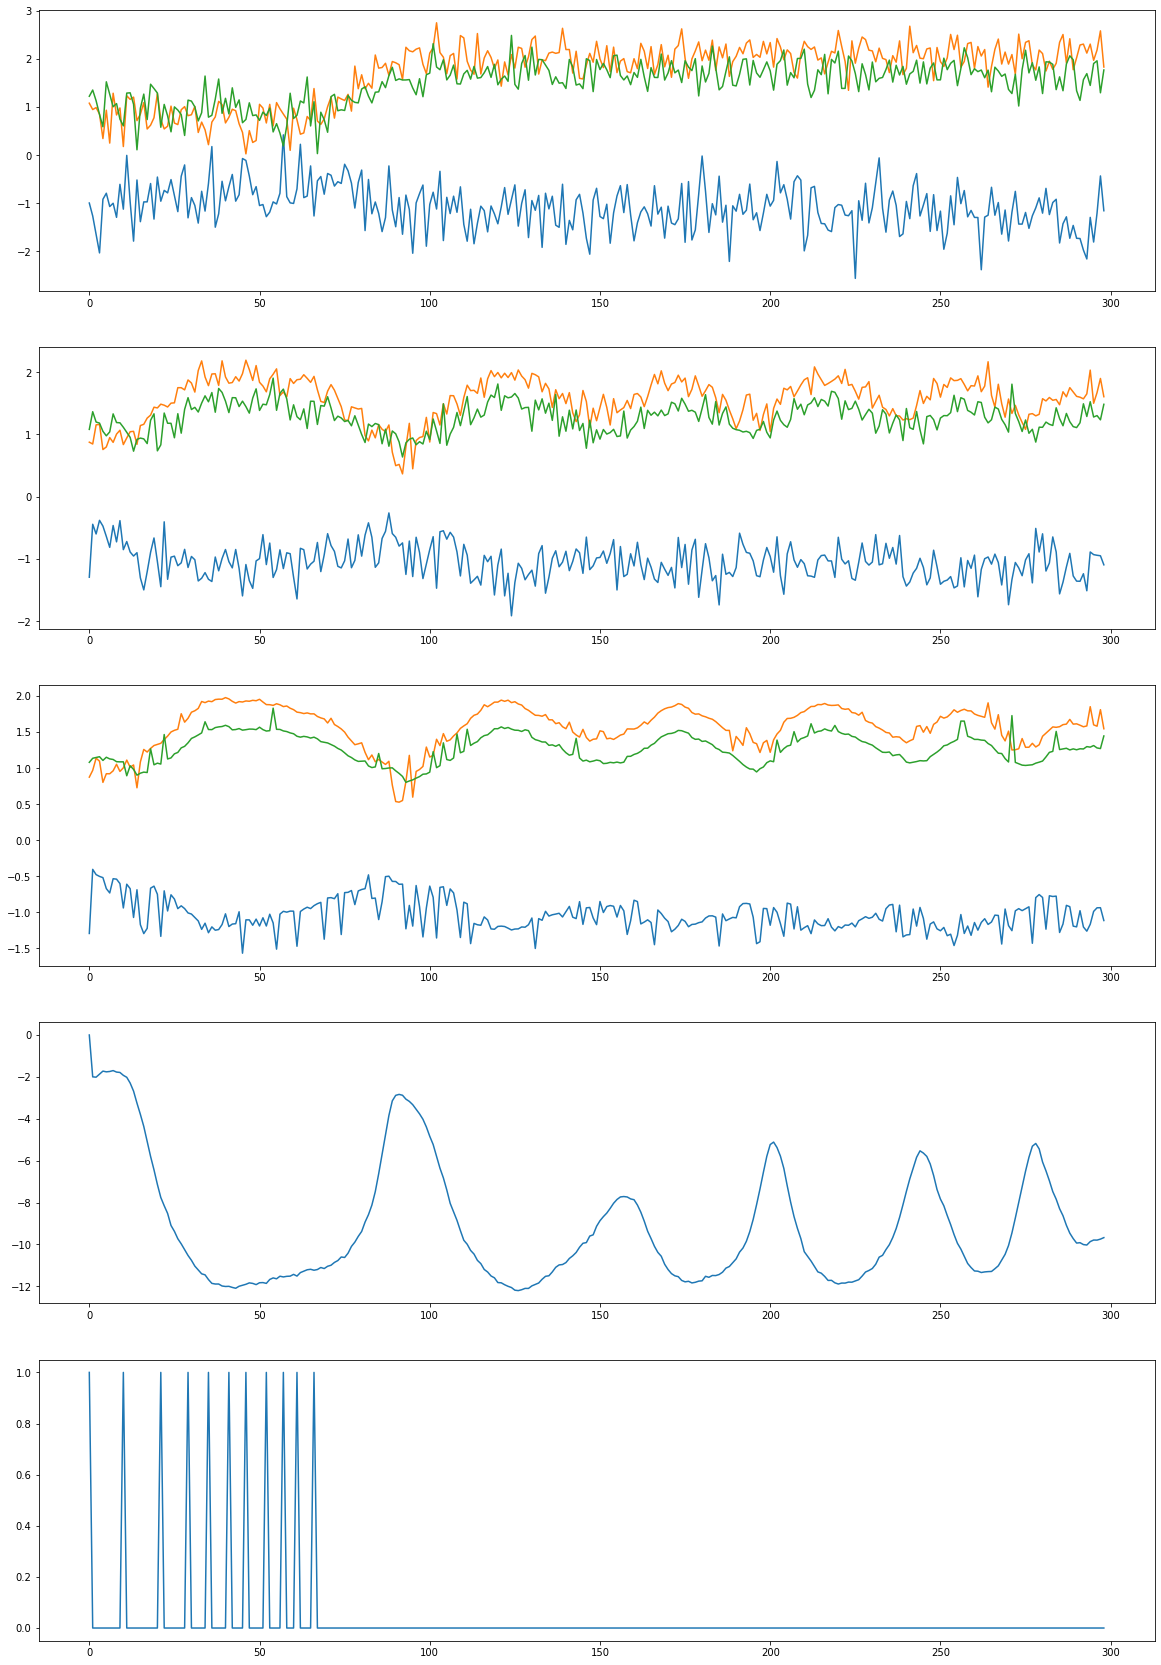

In [19]:
b = np.swapaxes(actual,0,1)
print(b.shape)
actual_rew = b[-1,:]

next_zs = np.zeros(shape = (32,299))
next_mus = np.zeros(shape = (32,299))
next_rews = np.zeros(shape = (1,299))
# next_z = np.copy(obs)
# print(next_z.shape)
next_z = obs[idx,:]

next_mus[:,0] = next_z[:32]
next_zs[:,0] = next_z[:32]
next_rews[:,0] = next_z[-1]

for i in range(1,299):
    next_z, chosen_mu, chosen_log_sigma, chosen_pi, rew_pred, next_reward, next_h, next_c = sample_next_mdn_output(next_z, next_h, next_c)
    next_mus[:,i] = chosen_mu
    next_zs[:,i] = next_z
    next_rews[:,i] = rew_pred
    
    next_z_decoded = vae.decoder.predict(np.array([next_z]))[0]
    
#     plt.gca().cla() 
#     plt.imshow( next_z_decoded)
# #     plt.show()
#     display.clear_output(wait=True)
#     display.display(plt.gcf()) 
    
    next_z = np.concatenate([next_z, [-1,1,0], [next_reward]])

plt.figure(figsize=(20,30))
for i in hot_zs:
    plt.subplot(511)
    plt.plot( b[i,:])
    plt.subplot(512)
    plt.plot( next_zs[i,:])
    plt.subplot(513)
    plt.plot( next_mus[i,:])
    
plt.subplot(514)
plt.plot(next_rews[0,:])

plt.subplot(515)
plt.plot(actual_rew[:])
    
# print(next_zs)
    